# MNIST digit classifier - Jorge Martínez (AIAO M2BI)

### Load modules

In [114]:
import numpy as np
from pandas import read_csv
from sklearn import preprocessing

# Tensorflow and keras import
from keras import layers, models, utils, callbacks, optimizers

# # Utils to manipulate data
from keras.utils import to_categorical

# # Keras models
from keras.models import Sequential

# # Keras layers
from keras.layers import Dense, Dropout
from keras.layers import TimeDistributed
from keras.layers import add
from keras.layers import Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten


# # Callback (for learning/optimize)
from keras.callbacks  import TensorBoard
from scikeras import wrappers
from scikeras.wrappers import KerasClassifier


# # Data analysis and protocol
from sklearn.model_selection     import cross_val_score
from sklearn.model_selection     import train_test_split
from sklearn.model_selection     import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# # Plotting
import matplotlib.pyplot as plt
import seaborn as sns

### Load data and visualise it

In [115]:
# Load the data
train_images = np.load('../data/train_images.npy')
train_labels = np.load('../data/train_labels.npy')
test_images = np.load('../data/test_images.npy')
test_labels = np.load('../data/test_labels.npy')

In [147]:
# Check shape of the data
print("Shape of the train images:", train_images.shape)
print("Number of train labels:", train_labels.shape)
print("Shape of the test images:", test_images.shape)
print("Number of test labels:", test_labels.shape)

# Check how many classes there are
print("Classes in the train set:", np.unique(train_labels))
print("Classes in the test set:", np.unique(test_labels)) 

Shape of the train images: (60000, 28, 28, 1)
Number of train labels: (60000,)
Shape of the test images: (10000, 28, 28, 1)
Number of test labels: (10000,)
Classes in the train set: [0 1 2 3 4 5 6 7 8 9]
Classes in the test set: [0 1 2 3 4 5 6 7 8 9]


* The data consists of images in black and white (1 channel) of 28x28px
* The train set consists of 60,000 images
* The test set consist of 10,000 images

In [ ]:
# Display the values of the first training image
print("First Training Image Values:")
print(train_images[0].reshape(28, 28))

# Display the values of the first test image
print("\nFirst Test Image Values:")
print(test_images[0].reshape(28, 28))

* The train set is normalized but not the test set

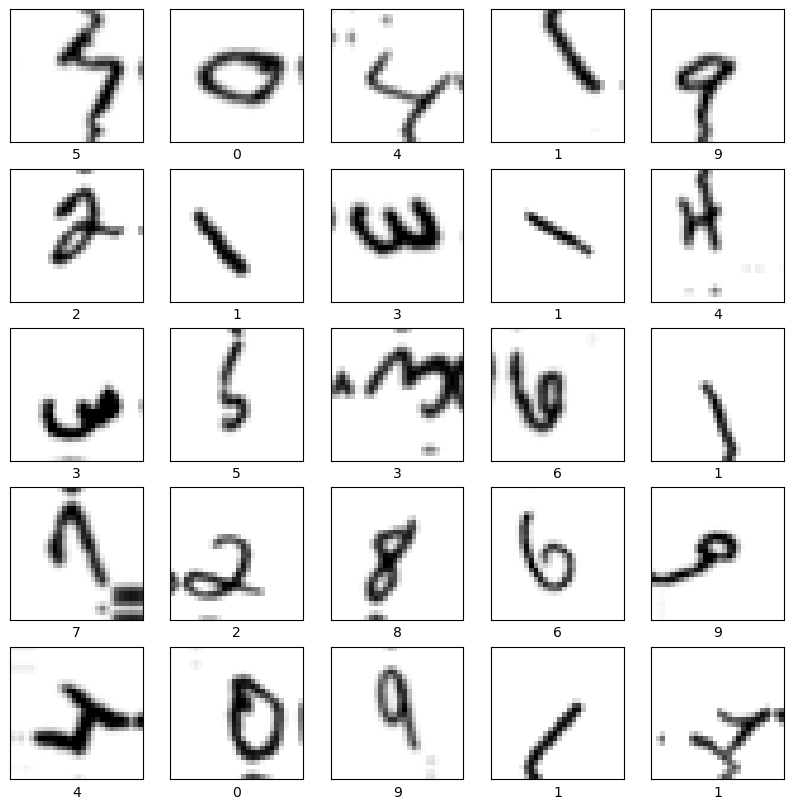

In [117]:
# Visualize the first 25 images of the train set
plt.figure(figsize=[10, 10])
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])

plt.show()

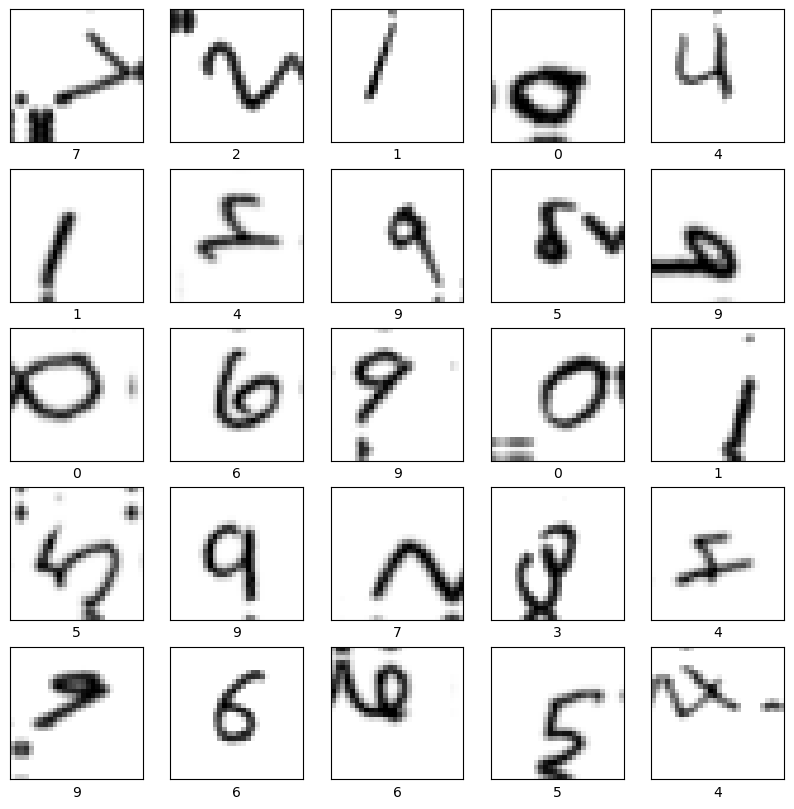

In [118]:
# Visualize the first 25 images of the test set
plt.figure(figsize=[10, 10])
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    plt.xlabel(test_labels[i])

plt.show()

## DNN model

### Prepare the data

Before building our DNN model, we need to prepare the images to go into the neural network. 
In this case, the images are reshaped into 2S arrays as DNN expects a 1D input vector.
As we have seen previously, the test set is not normalised so it is normalised here.
Lastly, the labels (Y) are passed to one-hot encoding

In [119]:
# Pre-format the images
train_images_dnn = train_images.astype("float32")
test_images_dnn = test_images.astype("float32")

num_pixels = train_images_dnn.shape[1] * train_images_dnn.shape[2]

# Flatten images
train_images_dnn = train_images_dnn.reshape(train_images_dnn.shape[0], num_pixels)
test_images_dnn = test_images_dnn.reshape(test_images_dnn.shape[0], num_pixels)

# Normalization
test_images_dnn /= 255

# One-hot encoding the target labels
num_classes = len(np.unique(train_labels))
train_labels_dnn = to_categorical(train_labels, num_classes)
test_labels_dnn = to_categorical(test_labels, num_classes)

### Build the model

The architecture of this model begins with an input layer that receives the flattened images

The first hidden layer features 256 neurons activated by the ReLU function and is followed by a second hidden layer with 128 neurons, also employing ReLU activation 

To mitigate the risk of overfitting, a dropout layer is introduced, randomly disabling 30% of the neurons during training

Finally, the output layer has the 10 expected classes and uses the softmax activation function to generate a probability distribution across these

The model is compiled with the RMSprop optimizer and categorical cross-entropy loss, allowing it to effectively learn from the data and optimize its performance based on accuracy metrics

In [120]:
def dense_model(num_pixels, num_classes):
    model = Sequential([
        Dense(256, activation='relu', input_dim=num_pixels),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer= optimizers.RMSprop(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Then use it like this:
model1 = dense_model(num_pixels, num_classes)
model1.summary()


/opt/miniconda3/envs/aiao-env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_43 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [148]:
# Flatten the images
dense_history = model1.fit(train_images_dnn, train_labels_dnn, validation_split=0.3, epochs=50, batch_size=100)

Epoch 1/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1039 - loss: 2.3649 - val_accuracy: 0.1075 - val_loss: 2.3046
Epoch 2/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1135 - loss: 2.3041 - val_accuracy: 0.1079 - val_loss: 2.3022
Epoch 3/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1155 - loss: 2.3015 - val_accuracy: 0.1079 - val_loss: 2.3031
Epoch 4/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1104 - loss: 2.3020 - val_accuracy: 0.1079 - val_loss: 2.3017
Epoch 5/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1135 - loss: 2.3014 - val_accuracy: 0.1079 - val_loss: 2.3020
Epoch 6/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1145 - loss: 2.3012 - val_accuracy: 0.1079 - val_loss: 2.3020
Epoch 7/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1119 - loss: 2.3014 - val_accuracy: 0.1079 - val_loss: 2.3021
Epoch 8/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1168 - loss: 2.3009 - val_accuracy: 0.

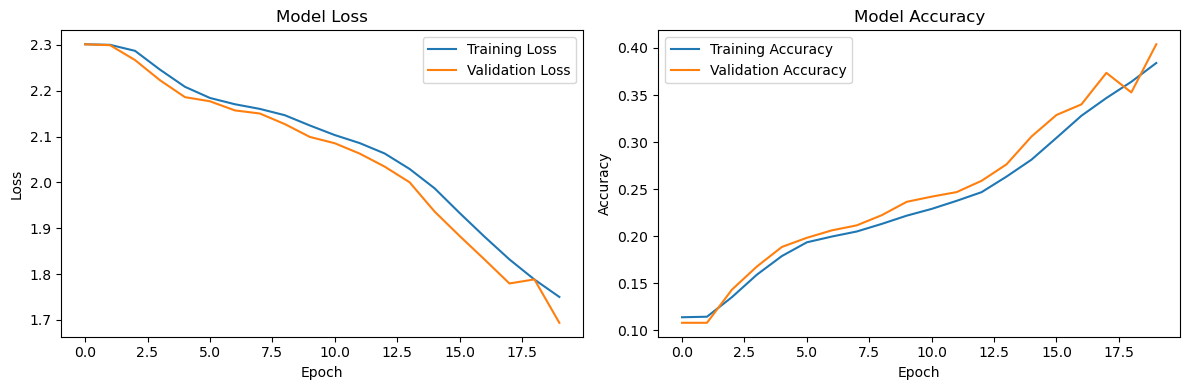

In [122]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(dense_history.history['loss'], label='Training Loss')
plt.plot(dense_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(dense_history.history['accuracy'], label='Training Accuracy')
plt.plot(dense_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

### Evaluate the performance of the model

#### Evaluate performance on the train set

In [123]:
labs_pred_proba = model1.predict(train_images_dnn)

print(classification_report(np.argmax(train_labels_dnn, axis = 1), np.argmax(labs_pred_proba, axis = 1)))

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step
              precision    recall  f1-score   support

           0       0.58      0.75      0.65      5923
           1       0.48      0.85      0.61      6742
           2       0.28      0.19      0.23      5958
           3       0.31      0.24      0.27      6131
           4       0.37      0.25      0.30      5842
           5       0.26      0.10      0.15      5421
           6       0.41      0.56      0.47      5918
           7       0.39      0.50      0.44      6265
           8       0.28      0.21      0.24      5851
           9       0.39      0.35      0.37      5949

    accuracy                           0.41     60000
   macro avg       0.38      0.40      0.37     60000
weighted avg       0.38      0.41      0.38     60000



[Text(0.5, 23.52222222222222, 'y_pred'),
 Text(50.722222222222214, 0.5, 'y_true')]

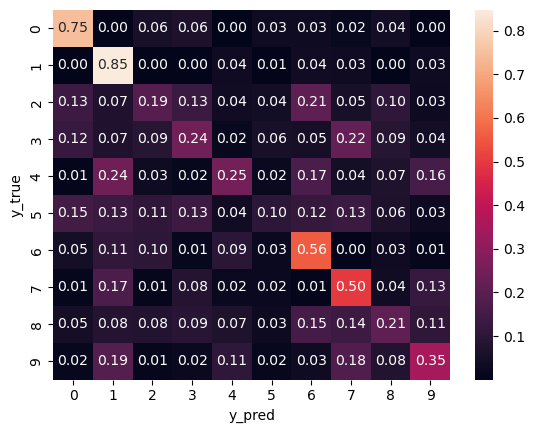

In [124]:
cm = sns.heatmap(confusion_matrix(np.argmax(train_labels_dnn, axis = 1),  np.argmax(labs_pred_proba, axis = 1), normalize = "true"),
                 annot = True, fmt='.2f')
cm.set(xlabel = "y_pred", ylabel = "y_true")

#### Evaluation on the test set

In [74]:
# On the test set
labs_pred_proba = model1.predict(test_images_dnn)

print(classification_report(np.argmax(test_labels_dnn, axis = 1), np.argmax(labs_pred_proba, axis = 1)))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       980
           1       0.95      0.96      0.96      1135
           2       0.83      0.82      0.82      1032
           3       0.82      0.84      0.83      1010
           4       0.79      0.78      0.78       982
           5       0.73      0.77      0.75       892
           6       0.81      0.89      0.84       958
           7       0.86      0.84      0.85      1028
           8       0.85      0.74      0.79       974
           9       0.81      0.76      0.78      1009

    accuracy                           0.84     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.84      0.84      0.84     10000



[Text(0.5, 23.52222222222222, 'y_pred'),
 Text(50.722222222222214, 0.5, 'y_true')]

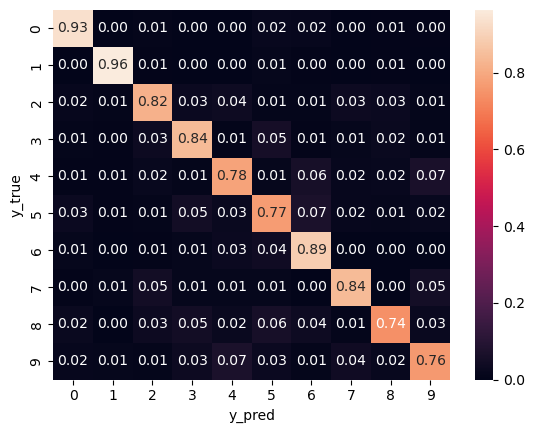

In [75]:
cm = sns.heatmap(confusion_matrix(np.argmax(test_labels_dnn, axis = 1),  np.argmax(labs_pred_proba, axis = 1), normalize = "true"),
                 annot = True, fmt='.2f')
cm.set(xlabel = "y_pred", ylabel = "y_true")

In [76]:
# Save the model
# model1.save('../res/model_dense.h5')

## CNN model

### Prepare the data

In [125]:
# Pre-format the images
train_images_cnn = train_images.astype("float32")
test_images_cnn = test_images.astype("float32")

# Normalize
test_images_cnn /= 255

# Reshape to have a single channel (black & white)
train_images_cnn = train_images_cnn.reshape(train_images_cnn.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

# One hot encoding
num_classes = len(np.unique(train_labels))
train_labels_cnn = to_categorical(train_labels, num_classes)
test_labels_cnn = to_categorical(test_labels, num_classes)

# Shuffle the data
np.random.seed(0)
shuffle_index = np.random.permutation(train_images_cnn.shape[0])
train_images_cnn = train_images_cnn[shuffle_index]
train_labels_cnn = train_labels_cnn[shuffle_index]

### Build the model

In [126]:
def cnn_model(num_pixels, num_classes):
    model = Sequential([
        Conv2D(input_shape = train_images_cnn.shape[1:],
                filters = 32,
                kernel_size = (3,3),
                activation = "relu"),
        MaxPooling2D(pool_size = (2,2)),
        Conv2D(filters = 64,
                kernel_size = (3,3),
                activation = "relu"),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer = optimizers.RMSprop(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Then use it like this:
model2 = cnn_model(num_pixels, num_classes)
model2.summary()


/opt/miniconda3/envs/aiao-env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [127]:
cnn_history = model2.fit(train_images_cnn, train_labels_cnn, 
                         validation_split=0.3, 
                         epochs=20, 
                         batch_size=100)

Epoch 1/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3010 - loss: 1.9530 - val_accuracy: 0.5952 - val_loss: 1.2341
Epoch 2/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.6267 - loss: 1.1466 - val_accuracy: 0.6793 - val_loss: 0.9838
Epoch 3/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.7196 - loss: 0.8873 - val_accuracy: 0.7712 - val_loss: 0.7374
Epoch 4/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.7864 - loss: 0.7062 - val_accuracy: 0.7951 - val_loss: 0.6720
Epoch 5/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.8226 - loss: 0.5813 - val_accuracy: 0.8258 - val_loss: 0.5587
Epoch 6/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.8517 - loss: 0.4928 - val_accuracy: 0.8501 - val_loss: 0.4858
Epoch 7/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.8713 - loss: 0.4309 - val_accuracy: 0.8705 - val_loss: 0.4304
Epoch 8/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.8828 - loss: 0.3860 - val_acc

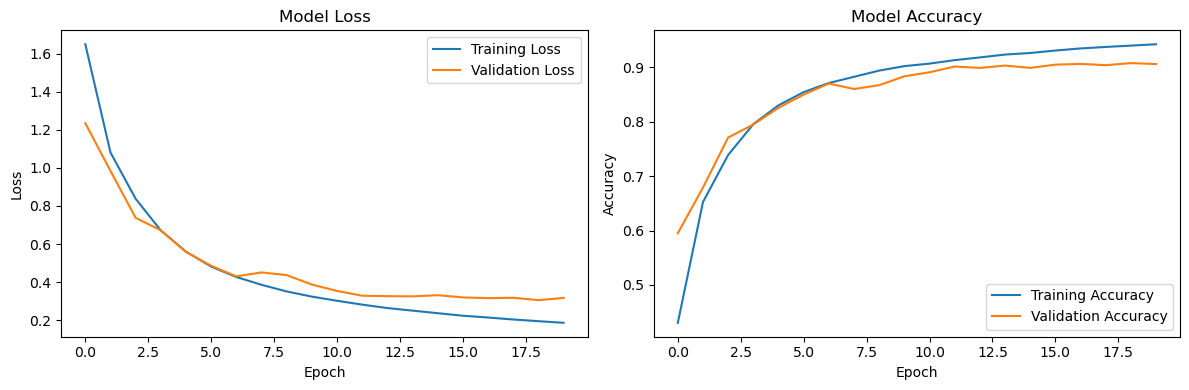

In [128]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

### Evaluate the performance of the model

#### Evaluate performance on the train set

In [129]:
labs_pred_proba = model2.predict(train_images_cnn)

print(classification_report(np.argmax(train_labels_cnn, axis = 1), np.argmax(labs_pred_proba, axis = 1)))

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5923
           1       0.96      0.98      0.97      6742
           2       0.95      0.86      0.91      5958
           3       0.92      0.96      0.94      6131
           4       0.90      0.95      0.93      5842
           5       0.92      0.95      0.93      5421
           6       0.96      0.95      0.95      5918
           7       0.89      0.93      0.91      6265
           8       0.97      0.89      0.92      5851
           9       0.94      0.91      0.92      5949

    accuracy                           0.94     60000
   macro avg       0.94      0.94      0.94     60000
weighted avg       0.94      0.94      0.94     60000



[Text(0.5, 23.52222222222222, 'y_pred'),
 Text(50.722222222222214, 0.5, 'y_true')]

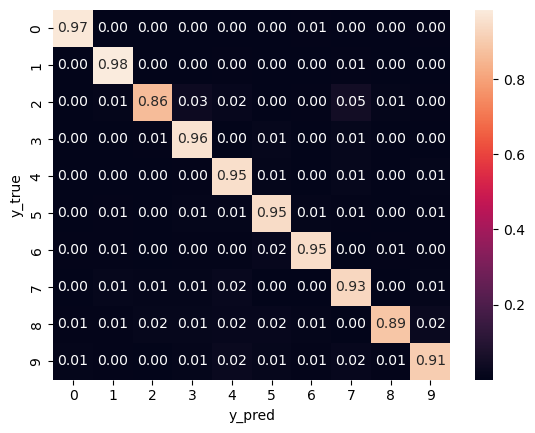

In [130]:
cm = sns.heatmap(confusion_matrix(np.argmax(train_labels_cnn, axis = 1),  np.argmax(labs_pred_proba, axis = 1), normalize = "true"),
                 annot = True, fmt='.2f')
cm.set(xlabel = "y_pred", ylabel = "y_true")

#### Evaluation on the test set

In [131]:
# On the test set
labs_pred_proba = model2.predict(test_images_cnn)

print(classification_report(np.argmax(test_labels_cnn, axis = 1), np.argmax(labs_pred_proba, axis = 1)))

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       980
           1       0.95      0.99      0.97      1135
           2       0.92      0.84      0.88      1032
           3       0.88      0.95      0.91      1010
           4       0.88      0.91      0.90       982
           5       0.87      0.91      0.89       892
           6       0.93      0.92      0.93       958
           7       0.86      0.90      0.88      1028
           8       0.96      0.84      0.90       974
           9       0.90      0.87      0.89      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



[Text(0.5, 23.52222222222222, 'y_pred'),
 Text(50.722222222222214, 0.5, 'y_true')]

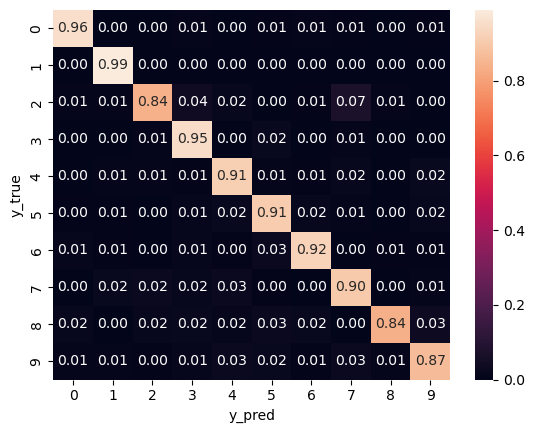

In [132]:
cm = sns.heatmap(confusion_matrix(np.argmax(test_labels_cnn, axis = 1),  np.argmax(labs_pred_proba, axis = 1), normalize = "true"),
                 annot = True, fmt='.2f')
cm.set(xlabel = "y_pred", ylabel = "y_true")

In [86]:
# Save the model
# model2.save('../res/model_conv.h5')

## CNN model - optim.

### Build the model

In [133]:
def cnn_model_optim(num_pixels, num_classes):
    model = Sequential([
        Conv2D(input_shape = train_images_cnn.shape[1:],
                filters = 32,
                kernel_size = (3,3),
                activation = "relu"),
        MaxPooling2D(pool_size = (2,2)),
        Conv2D(filters = 64,
                kernel_size = (3,3),
                activation = "relu"),
        MaxPooling2D(pool_size = (2,2)),
        Dropout(0.25),
        Flatten(),
        Dense(units = 128,
                activation = "relu"),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=optimizers.RMSprop(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Then use it like this:
model_cnn_optim = cnn_model(num_pixels, num_classes)
model_cnn_optim.summary()


/opt/miniconda3/envs/aiao-env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [134]:
cnn_optim_history = model_cnn_optim.fit(train_images_cnn, train_labels_cnn, 
                         validation_split=0.3, 
                         epochs=20, 
                         batch_size=100)

Epoch 1/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - accuracy: 0.3142 - loss: 1.9272 - val_accuracy: 0.6090 - val_loss: 1.2249
Epoch 2/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.6250 - loss: 1.1440 - val_accuracy: 0.7061 - val_loss: 0.9310
Epoch 3/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.7223 - loss: 0.8800 - val_accuracy: 0.7668 - val_loss: 0.7504
Epoch 4/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.7898 - loss: 0.6945 - val_accuracy: 0.7936 - val_loss: 0.6651
Epoch 5/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.8240 - loss: 0.5771 - val_accuracy: 0.8352 - val_loss: 0.5465
Epoch 6/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.8489 - loss: 0.4943 - val_accuracy: 0.8518 - val_loss: 0.4841
Epoch 7/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.8670 - loss: 0.4359 - val_accuracy: 0.8634 - val_loss: 0.4486
Epoch 8/20
420/420 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.8826 - loss: 0.3889 - 

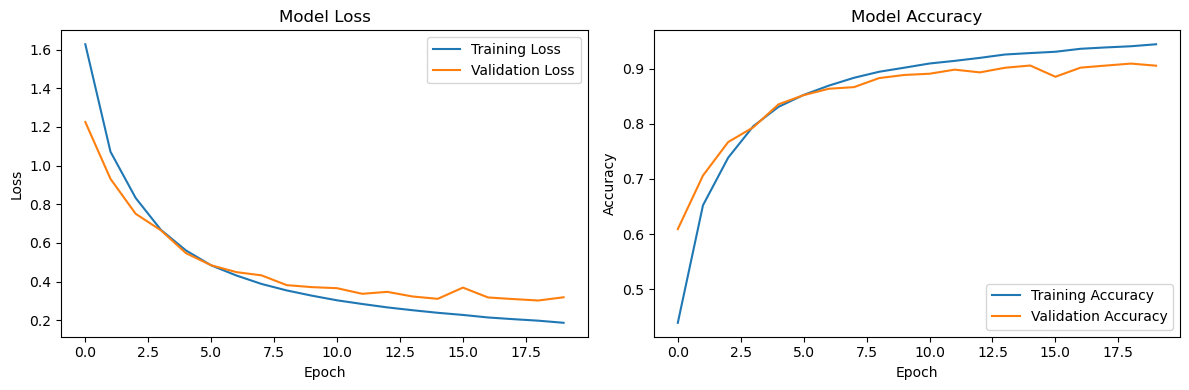

In [135]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(cnn_optim_history.history['loss'], label='Training Loss')
plt.plot(cnn_optim_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_optim_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_optim_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

### Evaluate the performance of the model

In [137]:
test_loss_cnn_optim, test_accuracy_cnn_optim = model_cnn_optim.evaluate(test_images_cnn, test_labels_cnn)
print(f"Test accuracy: {test_accuracy_cnn_optim:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9021 - loss: 0.3377
Test accuracy: 0.9112


In [ ]:
# Make predictions
labs_pred = model_cnn_optim.predict(test_images_cnn)

# Convert one-hot encoded labels back to class indices
labs_test_classes = np.argmax(test_labels_cnn, axis = 1)
labs_pred_classes = np.argmax(labs_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(np.argmax(test_labels_cnn, axis = 1),  np.argmax(labs_pred_proba, axis = 1), normalize="true")

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='YlOrBr')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [138]:
# On the test set
labs_pred_proba = model_cnn_optim.predict(test_images_cnn)

print(classification_report(np.argmax(test_labels_cnn, axis = 1), np.argmax(labs_pred_proba, axis = 1)))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       980
           1       0.96      0.99      0.97      1135
           2       0.93      0.86      0.89      1032
           3       0.92      0.95      0.93      1010
           4       0.89      0.90      0.90       982
           5       0.89      0.90      0.89       892
           6       0.90      0.93      0.92       958
           7       0.84      0.90      0.87      1028
           8       0.94      0.83      0.88       974
           9       0.89      0.90      0.89      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



[Text(0.5, 23.52222222222222, 'y_pred'),
 Text(50.722222222222214, 0.5, 'y_true')]

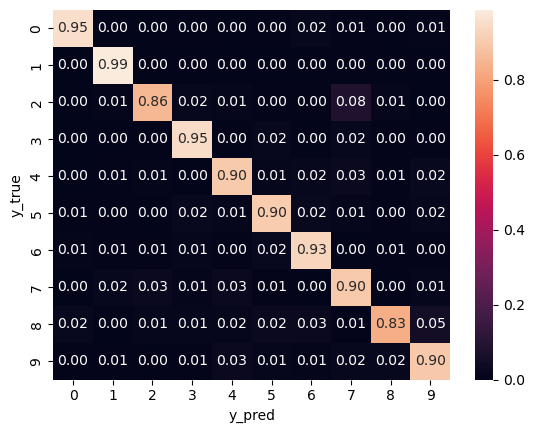

In [139]:
cm = sns.heatmap(confusion_matrix(np.argmax(test_labels_cnn, axis = 1),  np.argmax(labs_pred_proba, axis = 1), normalize = "true"),
                 annot = True, fmt='.2f')
cm.set(xlabel = "y_pred", ylabel = "y_true")

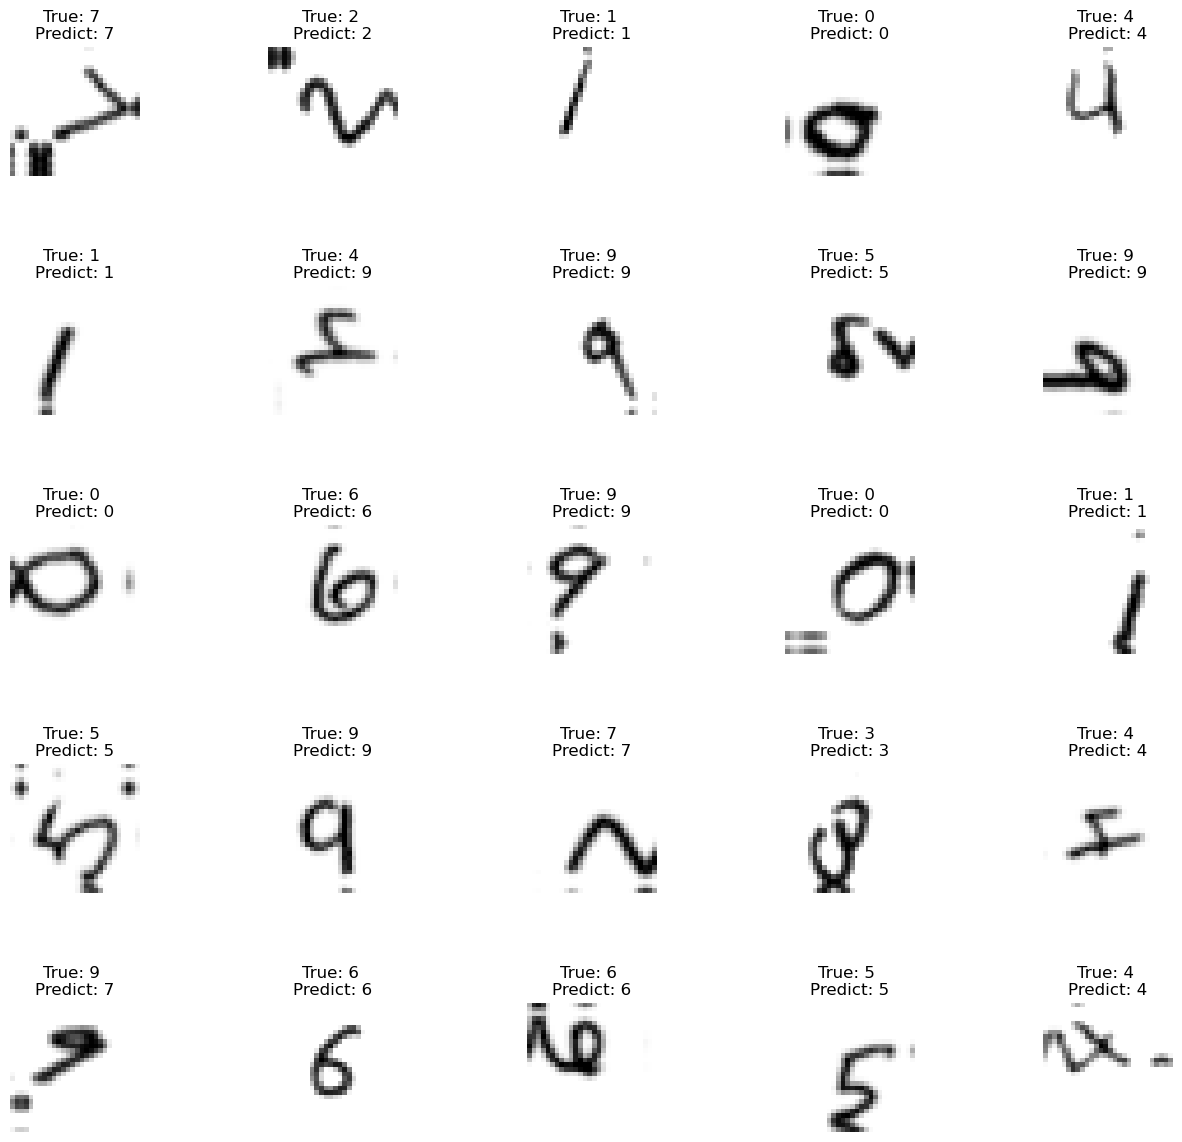

In [140]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.ravel()

for i in np.arange(0, 25):
    axes[i].imshow(test_images[i], cmap=plt.cm.binary)
    true_label = test_labels[i]
    predicted_label = np.argmax(labs_pred_proba[i])
    axes[i].set_title("True: %s \nPredict: %s" % (true_label, predicted_label))
    axes[i].axis('off')

plt.subplots_adjust(wspace=1)
plt.show()

In [95]:
# Save the model
# model2.save('../res/model_conv_opt.h5')

#### Evaluation with cross-validation

In [99]:
training = KerasClassifier(build_fn=cnn_model, num_pixels=num_pixels, num_classes=num_classes,
                           epochs=20, batch_size=100, verbose=0)

kfold = KFold(n_splits=5, shuffle=True)

cv_results = cross_val_score(training, train_images_cnn, 
                             train_labels_cnn, cv=kfold)

print("Cross validation accuracies:", cv_results)
print("Results Cross validation : %.2f%% (%.2f%%)"%(cv_results.mean()*100, cv_results.std()*100))

/opt/miniconda3/envs/aiao-env/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/miniconda3/envs/aiao-env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/miniconda3/envs/aiao-env/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/miniconda3/envs/aiao-env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: D

Cross validation accuracies: [0.95       0.95058333 0.9515     0.95325    0.94925   ]
Results Cross validation : 95.09% (0.14%)
